In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


In [2]:
import os
import numpy as np

In [10]:
train, test = chainer.datasets.get_mnist(ndim=3)

In [15]:
index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

datas = train[index_0and1]

print(len(datas[1]), len(train._datasets[1]))

train._datasets = datas
train._length = len(datas[1])

index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

datas = test[index_0and1]

print(len(datas[1]), len(test._datasets[1]))

test._datasets = datas
test._length = len(datas[1])

print(test[0][0].shape)

12665 12665
2115 2115
(1, 28, 28)


In [16]:
train[:2], test[:2]

([(array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.

In [17]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [43]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
#         if self.input_sep_flag:
#             act_var = []
#             for i in range(self.n_separate):
#                 var = F.expand_dims(x.reshape(BATCH_SIZE, self.n_separate, -1)[:, i, :], 1)
#                 act_var.append(self[i](var))
#         else:
#             act_var = []
#             for i in range(self.n_separate):
#                 act_var.append(self[i](x))
#         res = F.concat(act_var, axis=1)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepConv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(SepConv, self).__init__()
        with self.init_scope():
            self.conv1 = SepLink(n_separate=n_specific+1, link=L.Convolution2D,
                                in_channels=in_channels, out_channels=out_channels, ksize=3, stride=1)
#             self.l2 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
#             self.l3 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         print('x', len(x), list(map(lambda x:x.shape, x)))
        h1 = list(map(F.relu, self.conv1(x)))
#         print('h1', len(h1), list(map(lambda x:x.shape, h1)))
#         h2 = list(map(F.relu, self.l2(h1)))
#         print('h2', len(h2), list(map(lambda x:x.shape, h2)))
        _h = list(map(lambda x:F.mean(x, axis=(2, 3)), h1))
        outs = self.out(_h)
#         print('outs', len(outs), list(map(lambda x:x.shape, outs)))
        out = F.concat(outs, axis=1)
#         print('out', out.shape)
        return out

class Conv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(Conv, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels, ksize=3, stride=1)
#             self.l2 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h1 = F.relu(self.conv1(x))
#         h2 = F.relu(self.l2(h1))
        out = self.out(F.mean(h1, axis=(2, 3)))
        return out

In [44]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'conv_result_new'
    args_unit = 3
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    args_unit
#     model = L.Classifier(SepMLP(in_size, out_size))
    model = L.Classifier(Conv(None, out_channels=int(args_unit*3)))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepConv(None, out_channels=args_unit))
    print(model.predictor.conv1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [45]:
main()

GPU: 0
# unit: 3
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  1.58%
this epoch [#######################################...........] 78.96%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           0.634412    0.608943              0.469921       0.48303                   0.583887      
     total [#.................................................]  3.16%
this epoch [############################......................] 57.92%
       200 iter, 1 epoch / 50 epochs
    161.65 iters/sec. Estimated time to finish: 0:00:37.936238.
2           0.577948    0.546799              0.59874        0.766061                  1.28921       
     total [##................................................]  4.74%
this epoch [##################................................] 36.87%
      

20          0.140775    0.145639              0.949524       0.948182                  14.0909       
     total [####################..............................] 41.06%
this epoch [##########################........................] 52.90%
      2600 iter, 20 epoch / 50 epochs
    177.13 iters/sec. Estimated time to finish: 0:00:21.072642.
21          0.138974    0.143315              0.94937        0.949545                  14.807        
     total [#####################.............................] 42.64%
this epoch [###############...................................] 31.86%
      2700 iter, 21 epoch / 50 epochs
    176.24 iters/sec. Estimated time to finish: 0:00:20.610611.
22          0.137035    0.142243              0.94937        0.948636                  15.5414       
     total [######################............................] 44.22%
this epoch [#####.............................................] 10.82%
      2800 iter, 22 epoch / 50 epochs
    175.76 iters/sec. Esti

40          0.119983    0.124799              0.954841       0.955454                  28.699        
     total [########################################..........] 80.54%
this epoch [#############.....................................] 26.85%
      5100 iter, 40 epoch / 50 epochs
    174.75 iters/sec. Estimated time to finish: 0:00:07.052874.
41          0.119002    0.122875              0.954567       0.954545                  29.4205       
     total [#########################################.........] 82.12%
this epoch [##................................................]  5.80%
      5200 iter, 41 epoch / 50 epochs
    174.36 iters/sec. Estimated time to finish: 0:00:06.495019.
     total [#########################################.........] 83.70%
this epoch [##########################################........] 84.76%
      5300 iter, 41 epoch / 50 epochs
    175.65 iters/sec. Estimated time to finish: 0:00:05.878296.
42          0.117443    0.123997              0.955591       0.9

     total [#########.........................................] 18.95%
this epoch [#######################...........................] 47.49%
      1200 iter, 9 epoch / 50 epochs
    102.68 iters/sec. Estimated time to finish: 0:00:49.986436.
10          0.197959    0.197485              0.943386       0.943182                  12.3445       
     total [##########........................................] 20.53%
this epoch [#############.....................................] 26.45%
      1300 iter, 10 epoch / 50 epochs
    102.45 iters/sec. Estimated time to finish: 0:00:49.119832.
11          0.184923    0.185908              0.944331       0.944091                  13.5387       
     total [###########.......................................] 22.11%
this epoch [##................................................]  5.41%
      1400 iter, 11 epoch / 50 epochs
    102.28 iters/sec. Estimated time to finish: 0:00:48.223343.
     total [###########.......................................] 2

29          0.126345    0.130375              0.952936       0.952727                  35.7633       
     total [#############################.....................] 58.43%
this epoch [##########........................................] 21.44%
      3700 iter, 29 epoch / 50 epochs
    102.55 iters/sec. Estimated time to finish: 0:00:25.669625.
30          0.12484     0.128983              0.953622       0.953182                  36.9711       
     total [##############################....................] 60.01%
this epoch [..................................................]  0.39%
      3800 iter, 30 epoch / 50 epochs
    102.49 iters/sec. Estimated time to finish: 0:00:24.710845.
     total [##############################....................] 61.59%
this epoch [#######################################...........] 79.35%
      3900 iter, 30 epoch / 50 epochs
    103.16 iters/sec. Estimated time to finish: 0:00:23.579598.
31          0.123385    0.127867              0.95378        0.9

     total [################################################..] 97.91%
this epoch [###############################################...] 95.38%
      6200 iter, 48 epoch / 50 epochs
     103.6 iters/sec. Estimated time to finish: 0:00:01.278945.
49          0.101288    0.104678              0.96246        0.959545                  60.068        
     total [#################################################.] 99.49%
this epoch [#####################################.............] 74.34%
      6300 iter, 49 epoch / 50 epochs
    103.48 iters/sec. Estimated time to finish: 0:00:00.314073.
50          0.100298    0.102702              0.962835       0.961363                  61.2989       


In [46]:
in_size = None
out_size = 3
vanilla_model = L.Classifier(Conv(in_size, int(out_size*3)))
sep_model = L.Classifier(SepConv(in_size, out_size))
chainer.serializers.load_npz('./conv_result_new/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_conv_result_new/sep.model', sep_model)

In [47]:
van_mlp = vanilla_model.predictor
print(van_mlp.conv1.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.conv1.n_separate):
    print(sep_mlp.conv1[i].W.shape)

(9, 1, 3, 3)
(3, 1, 3, 3)
(3, 1, 3, 3)
(3, 1, 3, 3)


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

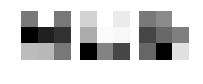

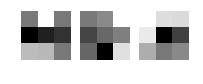

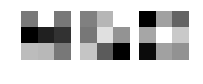

In [49]:
n_row = 1
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(van_mlp.conv1.W.data[int(i*j)].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

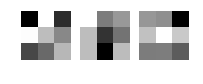

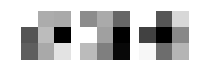

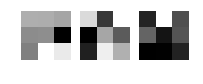

In [50]:
n_row = 1
n_col = 3
for i in range(1, 3+1):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(sep_mlp.conv1[i-1].W.data[j].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

[[-3.6099567   1.9815787   0.73611903  1.2214991   0.74915266  1.6904517
  -3.0730588   0.9396372   0.43052834]
 [ 3.4821222  -1.5971992  -0.6151498  -0.91771626 -1.2020564  -0.64285105
   2.5731046  -0.5140619  -0.6824057 ]]


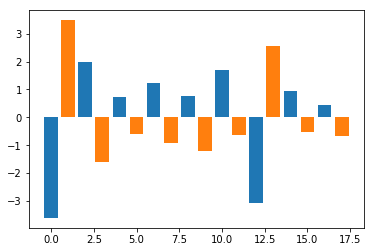

In [51]:
print(van_mlp.out.W.data)
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2+1, van_mlp.out.W.data[1])
plt.show()

[[ 0.38737658  2.0179496  -3.223989    1.6476151  -0.57526934 -4.0796356 ]]


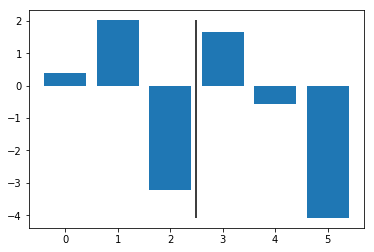

In [105]:
i = 0
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(3 - .5 , ymin=ymin, ymax=ymax)
plt.show()

[[ 0.8673133 -0.7452695  3.3651721  2.6799936 -1.5479809 -1.4909917]]


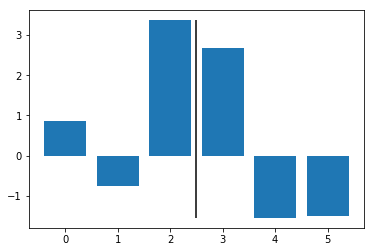

In [106]:
i = 1
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(3 - .5 , ymin=ymin, ymax=ymax)
plt.show()

In [89]:
test_data = test[:2]

In [90]:
test_image = np.asarray(list(map(lambda x: x[0], test_data)))
test_label = np.asarray(list(map(lambda x: x[1], test_data)))

In [91]:
van_feature_map = van_mlp.conv1(test_image)
sep_feature_map = sep_mlp.conv1([test_image])

In [92]:
van_feature_map.shape

(2, 9, 26, 26)

In [94]:
def norm(x):
    h = x.copy()
    h = h - h.min()
    h = h / h.max()
    return h

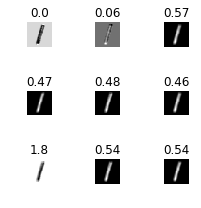

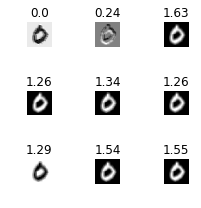

In [96]:
n_row = 3
n_col = 3
for i in range(1, 2+1):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(norm(van_feature_map.data)[i-1, j, :], cmap='gray')
        gap = np.mean(np.maximum(van_feature_map.data[i-1, j, :], 0))
        gap = np.round(gap, 2)
        plt.title(gap)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [102]:
len(sep_feature_map), sep_feature_map[0].shape

(3, (2, 3, 26, 26))

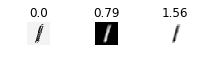

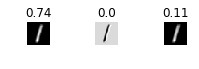

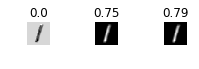

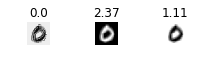

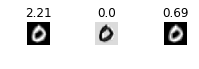

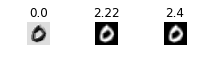

In [103]:
n_row = 1
n_col = 3
for i in range(1, 2+1):
    for n in range(3):
        plt.figure(figsize=(n_col, n_row))
        for j in range(int(n_row*n_col)):
            plt.subplot(n_row, n_col, j+1)
            plt.imshow(norm(sep_feature_map[n].data)[i-1, j, :], cmap='gray')
            gap = np.mean(np.maximum(sep_feature_map[n].data[i-1, j, :], 0))
            gap = np.round(gap, 2)
            plt.title(gap)
            plt.axis('off')
        plt.tight_layout()
        plt.show()